# Assignment 2

Import packages for data manipulation and visualization.

*Note: These packages are just for linearly algebra operations, data wrangling, and visualization. No ML methods are used.*

In [199]:
import pandas as pd
import numpy as np
import pprint as pp
from matplotlib import pyplot as plt
from sklearn import datasets

Pull data from file

In [200]:

# train_data = pd.read_csv('./data/body_measurements.csv')
dataset = datasets.load_iris()
classes = dataset.target
train_data = pd.DataFrame(dataset.data)
class_column='class'
train_data.rename({header: dataset.feature_names[int(header)] for header in train_data.columns}, axis=1)
train_data[class_column] = dataset.target_names[classes]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Let's take a look at some traits of our data, just to get a feel for it

In [201]:
print(train_data.dtypes)

0        float64
1        float64
2        float64
3        float64
class     object
dtype: object


We can see that we are working with numerical data, and two gender classes (male and female). I chose this data for this reason, as numerical data is ideal for PCA/LDA analysis.

Let's dive a little deeper and get some ranges and averages for the data.

In [202]:
uncat_averages = train_data.mean(0)
cat_data = train_data.groupby(class_column)
cat_averages = cat_data.mean()
cat_max = cat_data.max()
cat_min = cat_data.min()

print('Averages')
cat_averages

Averages


/var/folders/qz/cmcq5ghx3xsbqnsy89f5q8gw0000gn/T/ipykernel_37306/713710468.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  uncat_averages = train_data.mean(0)


,0,1,2,3
class,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


Although we see a lot of variation in the dataset 

In [203]:
print('Max')
cat_max

Max


,0,1,2,3
class,,,,
setosa,5.8,4.4,1.9,0.6
versicolor,7.0,3.4,5.1,1.8
virginica,7.9,3.8,6.9,2.5


In [204]:
print('Min')
cat_min


Min


,0,1,2,3
class,,,,
setosa,4.3,2.3,1.0,0.1
versicolor,4.9,2.0,3.0,1.0
virginica,4.9,2.2,4.5,1.4


### PCA

In [205]:
# Create a function that performs PCA on a given dataframe
def PCA(input_data, class_column, num_components, plot=True, test_data = None):
    dropped_data = input_data.drop(class_column, axis=1)
    normalized_data = (dropped_data-dropped_data.min(axis=0))/(dropped_data.max(axis=0)-dropped_data.min(axis=0))
    transposed_data = np.transpose(normalized_data)
    cov_matrix = np.cov(transposed_data)
    w,v = np.linalg.eigh(cov_matrix)
    print(sum(w))
    sort_indices = np.flip(np.argsort(w))
    eigenvectors = []
    eigenvalues = []
    for i in range(num_components):
        eigenvectors.append(v[sort_indices[i]])
        eigenvalues.append(w[sort_indices[i]])
    eigenvectors = np.array(eigenvectors).transpose()
    eigenvalues = np.abs(np.array(eigenvalues))
    train_projected = np.dot(dropped_data, eigenvectors)
    
    if test_data:
        test_projected = np.dot(test_data, eigenvectors)

    if plot and num_components == 1:
        fig, ax = plt.subplots()
        ax.scatter(train_projected[:,0], len(train_projected) * [0])
        if test_data:
            ax.scatter(test_projected[:, 0], len(test_projected) * [0], marker='x')
        plt.show()
    if plot and num_components == 2:
        fig, ax = plt.subplots()
        ax.scatter(train_projected[:,0], train_projected[:, 1])
        if test_data:
            ax.scatter(train_projected[:,0], train_projected[:, 1], marker='x')
        plt.show()
    if plot and num_components == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(train_projected[:,0], train_projected[:, 1], train_projected[:, 2])
        if test_data:
            ax.scatter3D(train_projected[:,0], train_projected[:, 1], train_projected[:, 2], marker='x')
        plt.show()
    print(f'{sum(eigenvalues) / sum(w) * 100}% of variance accounted for with {num_components} PCs')


0.27628262027767314


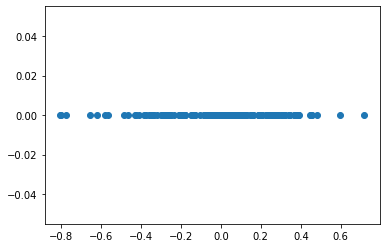

84.13603821315431% of variance accounted for with 1 PCs
0.27628262027767314


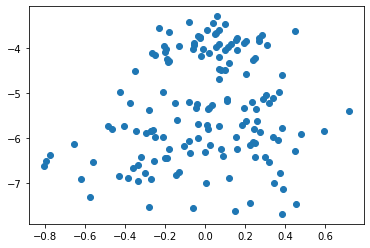

95.88784639918414% of variance accounted for with 2 PCs
0.27628262027767314


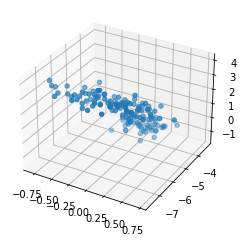

99.3614078079774% of variance accounted for with 3 PCs


In [206]:

PCA(train_data, class_column, 1)
PCA(train_data, class_column, 2)
PCA(train_data, class_column, 3)

Now we can see that PCA did seem to successfully find the axes with the highest variance, and that adding more components results in a higher percentage of the variance being accounted for. These results indicate that even with 3 PCs, there is still a large chunk of the variance that is unaccounted for, which means that the data that we are able to visualize isn't a great substitute for the original data. 

### LDA

This [tutorial](https://www.youtube.com/watch?v=9IDXYHhAfGA&t=396s&ab_channel=PythonEngineer) was a huge help to me for implementing the first section of the PCA algorithm in Python. The second half is extremely similar to the PCA algorithm.

In [207]:
def LDA(input_data, class_column, num_components, plot=True, test_data=None):
    dropped_data = input_data.drop(class_column, axis=1).to_numpy()
    normalized_data = (dropped_data-dropped_data.min(axis=0))/(dropped_data.max(axis=0)-dropped_data.min(axis=0))
    n_features = normalized_data.shape[1]
    categorized_data = input_data.groupby(class_column)
    classes = list(categorized_data.indices.keys())
    SW = np.zeros((n_features, n_features))
    SB = np.zeros((n_features, n_features))
    all_mean = normalized_data.mean(axis=0)
    for c in classes:
        XC = normalized_data[input_data[class_column] == c]
        c_mean = XC.mean(axis=0)
        SW += (XC-c_mean).T @ (XC-c_mean)
        c_samples = XC.shape[0]
        mean_diff = (c_mean - all_mean).reshape(n_features, 1)
        SB += c_samples * mean_diff @ mean_diff.T

    scatters = np.linalg.inv(SW) @ SB
    w,v = np.linalg.eig(scatters)
    v = v.T
    sort_indices = np.flip(np.argsort(np.abs(w)))
    eigenvectors = []
    eigenvalues = []

    for i in range(num_components):
        eigenvectors.append(v[sort_indices[i]])
        eigenvalues.append(w[sort_indices[i]])
    eigenvectors = np.array(eigenvectors).T
    eigenvalues = np.abs(np.array(eigenvalues))
    train_projected = np.dot(dropped_data, eigenvectors)

    colors = ['r', 'b', 'k']

    if test_data:
        test_projected = np.dot(test_data, eigenvectors)

    if plot and num_components == 1:
        fig, ax = plt.subplots()
        for i, c in enumerate(classes):
            data = train_projected[input_data[class_column] == c]
            color = colors[i]
            ax.scatter(data[:,0], len(data) * [0], edgecolors=color, facecolors='none')
            if test_data:
                t_data = test_projected.loc(test_projected[class_column] == c)
                ax.scatter(t_data[:,0], len(data) * [0], edgecolors=color, facecolors='none', marker='x')
        plt.show()
    if plot and num_components == 2:
        fig, ax = plt.subplots()
        for i, c in enumerate(classes):
            data = train_projected[input_data[class_column] == c]
            color = colors[i]
            ax.scatter(data[:,0], data[:, 1], edgecolors=color, facecolors='none')
            if test_data:
                t_data = test_projected.loc(test_projected[class_column] == c)
                ax.scatter(t_data[:,0], len(t_data) * [0], edgecolors=color, facecolors='none', marker='x')
        plt.show()
    if plot and num_components == 3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        for i, c in enumerate(classes):
            data = train_projected[input_data[class_column] == c]
            color = colors[i]
            ax.scatter3D(data[:,0], data[:, 1], data[:, 2], edgecolors=color, facecolors='none')
            if test_data:
                t_data = test_projected.loc(test_projected[class_column] == c)
                ax.scatter3D(t_data[:,0], t_data[:, 1], t_data[:, 2], edgecolors=color, facecolors='none', marker='x')
        plt.show()

    


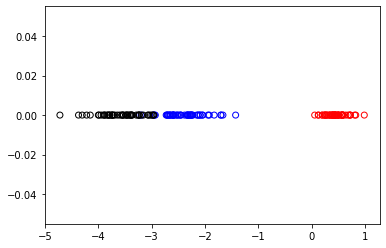

99.1212604965367% of variance accounted for with 1 PCs


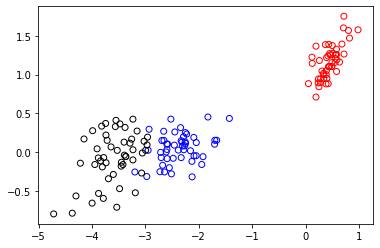

100.0% of variance accounted for with 2 PCs


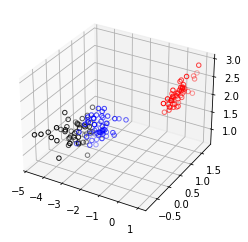

100.00000000000003% of variance accounted for with 3 PCs


In [208]:
LDA(train_data, class_column, 1)
LDA(train_data, class_column, 2)
LDA(train_data, class_column, 3)

### Results
The results of the LDA analysis were pretty disappointing, and I am not sure if I have a typo or a logical error in the data (any feedback would be appreciated). There is a single eigenvalue that is an order of magnitude larger than the others, so this axis is immediately the primary. The others don't contribute to better separation of the data. This implies to me that I made a mistake, but after a few hours of combing code I haven't been able to clear the issue up.

The PCA results looked like they correctly depicted the PCs with the highest variance, so I believe that this implementation was correct

### Conclusion
Although the LDA method did not yield quality results, the assignment did provide a solid understanding of PCA and LDA implentations. The lectures were great for understanding the source of the methods, and the assignment required a concrete implentation, research, and understanding.